<a href="https://colab.research.google.com/github/yonatan-co/food101_computer_vision_project/blob/main/10_milestone_project_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fc301c1b-5a4c-8931-1bf1-9ecce492f864)


In [2]:
!wget https://raw.githubusercontent.com/yonatan-co/t_helpers/main/helpers.py

--2022-09-27 08:49:34--  https://raw.githubusercontent.com/yonatan-co/t_helpers/main/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11449 (11K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  11.18K  --.-KB/s    in 0s      

2022-09-27 08:49:35 (82.1 MB/s) - ‘helpers.py’ saved [11449/11449]



In [120]:
from helpers import create_tensorboard_callback, walk_through_dir, plot_loss_curves, compare_historys, make_confusion_matrix, unzip_data

In [70]:
import tensorflow_datasets as tfds

--2022-09-27 10:36:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  41.8MB/s    in 5.6s    

2022-09-27 10:36:10 (88.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [72]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [6]:
class_names = ds_info.features['label'].names

## playing with the data

In [7]:
sample = train_data.take(1)

In [8]:
for image, label in sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)



  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 74
  Class name (str form): peking_duck
        


In [9]:
import matplotlib.pyplot as plt

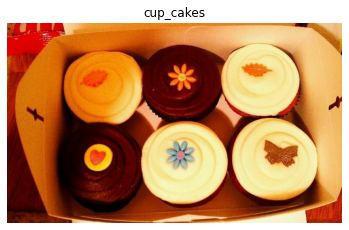

In [10]:
# plotting some images
for image, label in sample: 
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis(False)

In [11]:
import tensorflow as tf


In [76]:
# pre-processing our data

def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple


In [13]:
# before preprocessing

print(f"""
  image slice: {image[:2]} 
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)

# after preprocessing

preprocessed_image = preprocess_img(image, label)[0]

print(f"""
  preprocessed_image slice: {preprocessed_image[:2]} 
  Preprocessed Image shape: {preprocessed_image.shape}
  Preprocessed Image dtype: {preprocessed_image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  image slice: [[[199 100  15]
  [192  91   9]
  [202  95  23]
  ...
  [238 196 124]
  [237 195 123]
  [236 194 122]]

 [[210 110  25]
  [207 105  23]
  [194  86  13]
  ...
  [238 196 124]
  [236 194 122]
  [235 193 121]]] 
  Image shape: (306, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 29
  Class name (str form): cup_cakes
        

  preprocessed_image slice: [[[196.98405    96.515305   13.443877 ]
  [185.15625    75.776146   10.615431 ]
  [176.09981    62.711414    9.320153 ]
  ...
  [237.2455    192.6027    122.24549  ]
  [238.        196.        124.       ]
  [236.4598    194.4598    122.459785 ]]

 [[209.20886   106.47194    23.047512 ]
  [168.58833    56.285706    0.8501243]
  [166.6894     53.45121     2.834183 ]
  ...
  [236.62468   192.2172    121.85998  ]
  [238.50987   195.96077   125.60809  ]
  [235.9958    193.44669   123.09402  ]]] 
  Preprocessed Image shape: (224, 224, 3)
  Preprocessed Image dtype: <dtype: 'float32'>
  Target 

In [77]:

train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

## prepering our callbacks

In [15]:
# importing create-tensorboard callback
from helpers import create_tensorboard_callback

# create checkpoint callback
checkpoint_path = 'model-checkpoints/cp.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                          monitor='val_acc',
                                                          save_best_only=True,
                                                          save_weights_only=True,
                                                          verbose=0)

In [16]:
# apply mixed precison training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [17]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## building the model


In [18]:
from tensorflow import keras 
from tensorflow.keras import layers

In [19]:
from tensorflow.keras.layers.experimental import preprocessing

augmatation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(factor = 0.8),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.rescale(1./255.) if using ressnt
], name='augmatation_layer')

In [30]:


# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) 


outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [32]:
# fit the feutere extraction model

tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                checkpoint_callback])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220927-091023
Epoch 1/3
2368/2368 [==============================] - 234s 71ms/step - loss: 1.8184 - accuracy: 0.5575 - val_loss: 1.2318 - val_accuracy: 0.6758
Epoch 2/3
2368/2368 [==============================] - 167s 70ms/step - loss: 1.2927 - accuracy: 0.6651 - val_loss: 1.1195 - val_accuracy: 0.7034
Epoch 3/3
2368/2368 [==============================] - 168s 70ms/step - loss: 1.1430 - accuracy: 0.7014 - val_loss: 1.0905 - val_accuracy: 0.7082


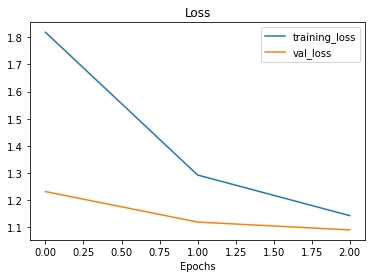

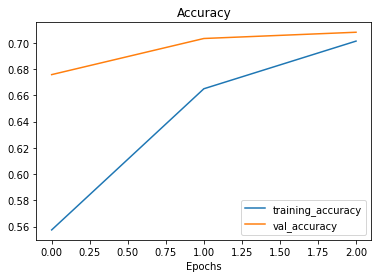

In [33]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [34]:
for layer in model.layers:
  layer.trainable = True

In [35]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training


In [36]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [37]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(lr=0.00001),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [38]:
history_101_food_classes_fine_tuned = model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)),
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), 
                                                                   checkpoint_callback, 
                                                                   early_stopping, 
                                                                   reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220927-092100
Epoch 1/100
2368/2368 [==============================] - 337s 136ms/step - loss: 0.8777 - accuracy: 0.7687 - val_loss: 0.9125 - val_accuracy: 0.7479 - lr: 1.0000e-05
Epoch 2/100
2368/2368 [==============================] - 325s 137ms/step - loss: 0.7668 - accuracy: 0.7971 - val_loss: 0.8740 - val_accuracy: 0.7590 - lr: 1.0000e-05
Epoch 3/100
2368/2368 [==============================] - 326s 137ms/step - loss: 0.6890 - accuracy: 0.8164 - val_loss: 0.8593 - val_accuracy: 0.7691 - lr: 1.0000e-05
Epoch 4/100
2368/2368 [==============================] - 326s 137ms/step - loss: 0.6217 - accuracy: 0.8352 - val_loss: 0.8522 - val_accuracy: 0.7717 - lr: 1.0000e-05
Epoch 5/100
2368/2368 [==============================] - 326s 137ms/step - loss: 0.5594 - accuracy: 0.8524 - val_loss: 0.8586 - val_accuracy: 0.7677 - lr: 1.0000e-05
Epoch 6/100
2367/2368 [============================>.] - ETA: 

In [39]:
model.evaluate(test_data)

790/790 [==============================] - 50s 64ms/step - loss: 0.8716 - accuracy: 0.7733


[0.8716309666633606, 0.7733069062232971]

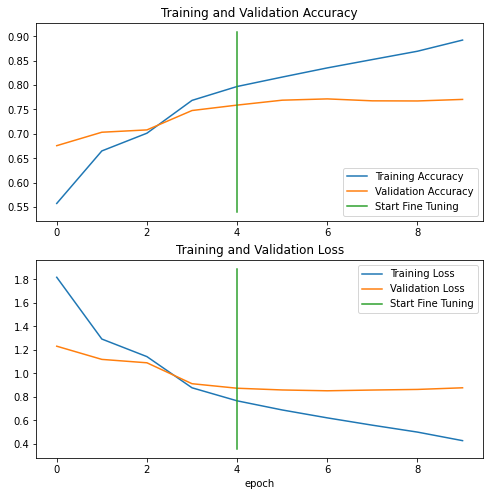

In [40]:
compare_historys(history_101_food_classes_feature_extract, history_101_food_classes_fine_tuned)

In [41]:
model.save('/content/drive/MyDrive/tensorflow models/deepFood')

In [101]:
def get_image(filename, scale, image_size=224):
  """
  function to get image redy to model prediction
  """

  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, size=(image_size, image_size))
  if scale:
    img = img / 255.
  return img

In [103]:
def predict_image(img_path, model, classes, scale=False):
  """
  a void function that plots model predictions from given
  img path and model.
  Args:
    img_path: the path of the image we want to predict on.
    model: the model we eant to prtediuct with.
    classes: the classes our model can predict from.
    scale(optional): if we want to scale the image when loading it.
  """
  img = get_image(img_path, scale=False)
  img_probs = model.predict(tf.expand_dims(img, axis=0))
  img_class = classes[img_probs.argmax()]

  plt.figure()
  plt.imshow(img/ 255.)
  plt.title(f"prediction: {img_class}, {img_probs.max():.2f} sure")

In [151]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-09-27 11:49:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.2’

custom_food_images. 100%[===================>]  12.58M  29.3MB/s    in 0.4s    

2022-09-27 11:49:57 (29.3 MB/s) - ‘custom_food_images.zip.2’ saved [13192985/13192985]



In [153]:
unzip_data('custom_food_images.zip')

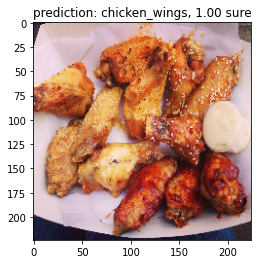

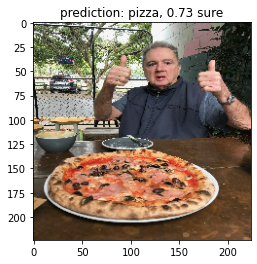

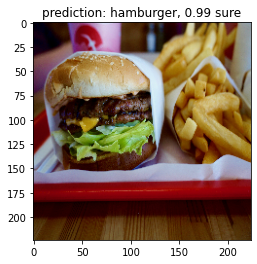

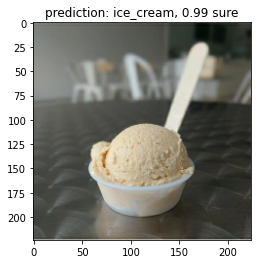

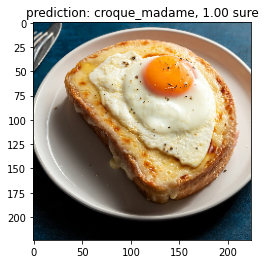

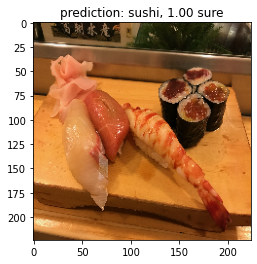

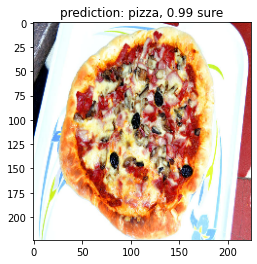

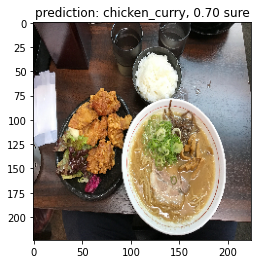

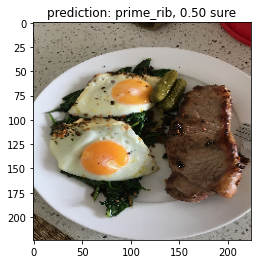

In [156]:
import os 

for path in os.listdir('/content/custom_food_images'):
  predict_image('/content/custom_food_images/' + path, model, class_names)